# Noise Reduction with PCA 
### Vasha DuTell: vasha@berkeley.edu

This tutorial goes over noise reduction using Principle Component Analysis (PCA), focused on implementation using SKLearn's PCA function. The example given is using a noisy set of time-series data, but could generalize to a movie or other dataset.

Useful resources for for further reading include:  
https://en.wikipedia.org/wiki/Principal_component_analysis  
https://en.wikipedia.org/wiki/Singular_value_decomposition  
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html  

Resources helpful to me in creating this include:  
https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com  
https://stackoverflow.com/questions/32750915/pca-inverse-transform-manually  

## Generate Data

We first generate dummy data - a set of sine waves with random phase offsets and uniform noise added 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 10
n_timepoints = 30

def gen_noisy_timeseries(timepoints):
    t = np.arange(timepoints)
    ts = np.sin(t) + np.random.rand(timepoints)
    return(ts)

d = np.array([gen_noisy_timeseries(n_timepoints) for s in range(n_samples)])
print(f'd shape: {d.shape}')


d shape: (10, 30)


Note that the shape of our data 'd' is number of samples by number of timepoints. 

Text(0.5, 1.0, 'Time Series Data That Needs Denoising')

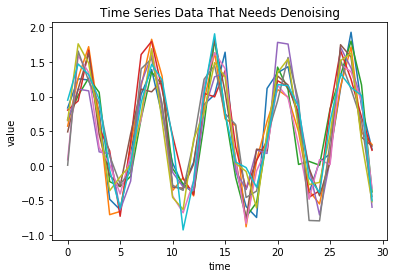

In [2]:
plt.plot(d.T);
plt.xlabel('time')
plt.ylabel('value')
plt.title('Time Series Data That Needs Denoising')

We have a bunch of traces, each of n_timepoints long overlaid, and they are noisy. Let's use PCA to denoise it!

## Run PCA

Now we'll import SKlearn's PCA funcionality to calculate PCA on our noisy data.

Note here that we call PCA on the data using n_components=None for now, and we'll reduce the number of components manually afterwards.

Another key point is that sklearn's PCA expects our data to be in a dimensions by samples format. In this case, our number of samples is the samples, and the timeoints is the dimension.

In [3]:
from sklearn.decomposition import PCA as sklearnPCA

d_mean = np.mean(d,axis=0)
#d_mean is also contained in sklearn_pca.mean_ after running

#define our PCA object
sklearn_pca = sklearnPCA(n_components=10)
#fit our PCA object to our data
sklearn_pca.fit(d)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Now we have a PCA object that's been fit to our noisy data.

Note that we calculated and retained the mean of our dataset. This is because SKlearn's PCA calculates PCA on the correlation matrix rather than the covariance matrix. (Correlation matrix is a normalized covariance matrix). Because of this, the mean is removed under the hood, and we'll need the mean values back when we move back into data space in order to reconstruct

## Extract PCA Variables
Now the fun part! Our sklearn_pca object has been fit to our data, and has parameters that we can pull out and use to manipulate our data.

Text(0.5, 1.0, 'PCA Explained Variance by PC')

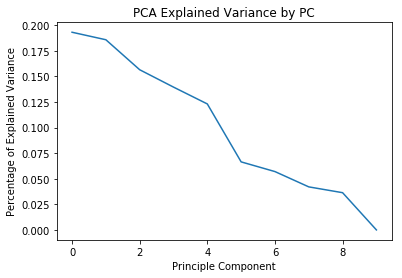

In [4]:
expl_var = sklearn_pca.explained_variance_ratio_
plt.plot(expl_var)
plt.xlabel('Principle Component')
plt.ylabel('Percentage of Explained Variance')
plt.title('PCA Explained Variance by PC')

Our first object of interest is the explained variance ratio. This tells us how much of the variance each principle component is responsible for. Since sklearn's pca function has already ordered them for us, we see the explained variance descending from largest to smallest. From the plot, we can see that most of the variance is explaind by the first two components. This means that the data lies in a lower dimensional space than it is measured, and we can likely get away with removing many of the later components and still reatin the signal.

In [5]:
tf = sklearn_pca.components_.T
print(f'TF shape: {tf.shape}')

TF shape: (30, 10)


Our second object of interest is a matrix, our transfer matrix $T_f$. This is also known as the eigenvectors. We transpose it because SKlearn gives us a transposed version of the eigenvector matrix we want. Note that it's a matrix of shape n_timepoints by n_samples. Truly though, the n_samples dimension now represents n_components/dimensions. This is because the number of dimensions is limited by the smaller of the two dimensions of our data. In this case the smaller dimension is n_samples.

## Project our data into PCA space
Using this transfer matrix, we can now take our data 'd', and move it from its n_timepoints space, to our n_components space. Let's call this new full projected matrix $P_f$. We'll do this by implementing the following equation:

$$P_f = DT_f$$

Since D is of shape n_samples by n_timepoints, calculating the dot product of $D$ by $T_f$, which is n_timepoints by n_dimensions will give us a $P_f$ of shape n_samples by n_dimensions.

In [6]:
pf = (d - d_mean)@tf
print(f'PF shape: {pf.shape}')

PF shape: (10, 10)


Now we've projected our data into PCA space. Each of our n_timepoints has a vector of n_dimensions long that represents how much it lies along each principle component dimension.

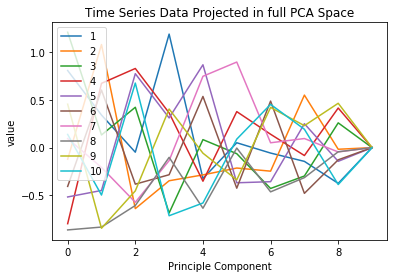

In [7]:
plt.plot(pf.T);
plt.xlabel('Principle Component')
plt.ylabel('value')
plt.title('Time Series Data Projected in full PCA Space')
plt.legend(np.arange(len(pf))+1)

Note how the first two principle components have the largest values. This supports the idea that the higher PCs are carrying less of the signal and more of the noise.

## Projection in SKL
As a sidenote, we could have use SKlearn's pca.transform() function to do calculate this automatically. Note here that we don't need to subtract the mean, this is happening under the hood.

PF_sktransform shape: (10, 10)


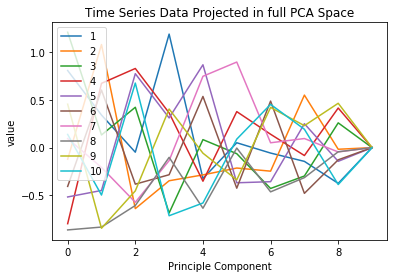

In [8]:
pf_skt = sklearn_pca.transform(d) 
print(f'PF_sktransform shape: {pf_skt.shape}')
plt.plot(pf_skt.T);
plt.xlabel('Principle Component')
plt.ylabel('value')
plt.title('Time Series Data Projected in full PCA Space')
plt.legend(np.arange(len(pf_skt))+1)

Note we get the same projection

## Reconstruct full $D$ from $P_f$

Now, lets see how we can go backwards from our $P_f$ back to our original data D. We'll do this by reversing the equation:

$$P_f = DT_f$$

And Instead do:

$$D = P_fT_f^T$$

In [9]:
d_fullrecon = pf@(tf.T) + d_mean
print(d_fullrecon.shape)

(10, 30)


Our reconstructed $D$ is the same shape as our origianal $D$. Let's see if it's the same:


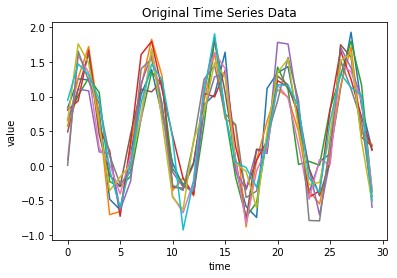

Text(0.5, 1.0, 'Reconstructed Time Series Data')

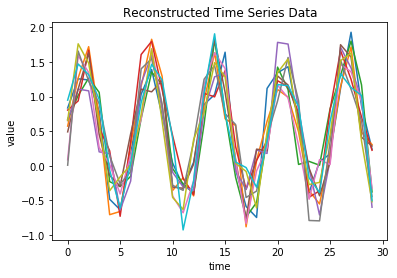

In [10]:
plt.plot(d.T);
plt.xlabel('time')
plt.ylabel('value')
plt.title('Original Time Series Data')
plt.show()

plt.plot(d_fullrecon.T);
plt.xlabel('time')
plt.ylabel('value')
plt.title('Reconstructed Time Series Data')

Text(0.5, 1.0, 'Correlation between D and D_recon')

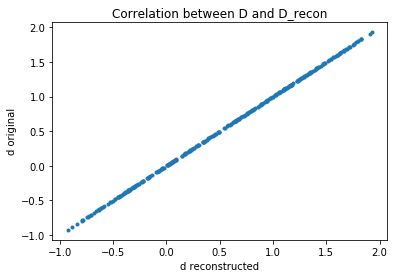

In [11]:
plt.plot(d_fullrecon.flatten(), d.flatten(),'.')
plt.xlabel('d reconstructed')
plt.ylabel('d original')
plt.title('Correlation between D and D_recon')

In [12]:
d_fullrecon = pf@(tf.T) + d_mean
print(d_fullrecon.shape)

(10, 30)


## Project $D$ into Reduced Space

Now let's denoise $D$ by removing some of the higher principle components we expect are noise. The first step is projecting it into a reduced PC space.

To do this we'll remove some eigenvectors from $T_f$, reducing it's dimensionality to get matrix $T_r$. SKlearn gave us a $T_f$ that was already sorted by decending order of explained variance ratio (related to eigenvalues), so we can just retain the first n columns of t to do this.

Since $T_f$'s number of dimensions is the second index, this is where we index to cut off the extra dimensions.

In [13]:
n_reduced_dims = 5

tr = tf[:,:n_reduced_dims]

print(f'TF shape: {tf.shape}')
print(f'TR shape: {tr.shape}')

TF shape: (30, 10)
TR shape: (30, 5)


We can then use $T_r$ to project the data into a reduced dimensional space, $P_r$.

$$P_r = DT_r$$

In [14]:
pr = d@tr
print(f'PR shape: {pr.shape}')

PR shape: (10, 5)


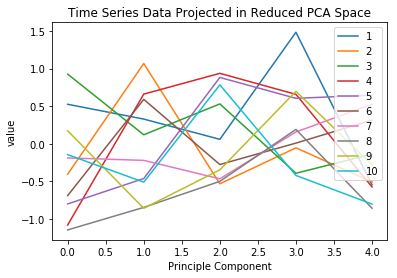

In [15]:
plt.plot(pr.T);
plt.xlabel('Principle Component')
plt.ylabel('value')
plt.title('Time Series Data Projected in Reduced PCA Space')
plt.legend(np.arange(len(pf))+1)

## Reconstruct denoised $D$ from $P_f$

Now, let's reconstruct $D$ using this reduced dimensionality representation, to see if we can remove noise this way.
We'll do this again by reversing the projection equation:

$$D_r = P_rT_r^T$$

In [16]:
dr = pr@(tr.T) + d_mean
print(f'Dr shape: {dr.shape}')

Dr shape: (10, 30)


Our reconstructed $D$ is the same shape as our origianal $D$. Let's see if it's the same:


Text(0.5, 1.0, 'Denoised Time Series Data')

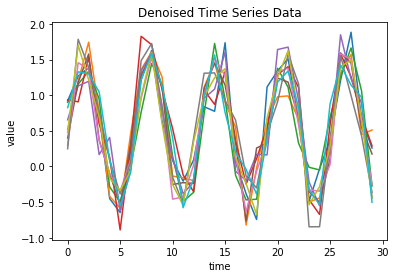

In [17]:
plt.plot(dr.T);
plt.xlabel('time')
plt.ylabel('value')
plt.title('Denoised Time Series Data')

Text(0.5, 1.0, 'Correlation between D and D_denoised')

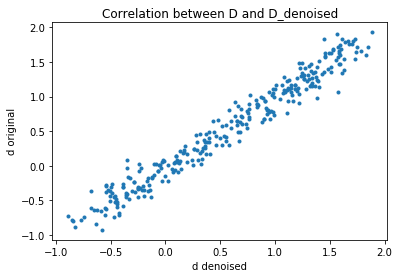

In [18]:
plt.plot(dr.flatten(), d.flatten(),'.')
plt.xlabel('d denoised')
plt.ylabel('d original')
plt.title('Correlation between D and D_denoised')

We've reconstructed! Notice that the correlation between our original d and our denoised version is a little less perfect, because we've thrown away information. 

## Loop through Progressively Fewer PC Reconstructions

Let's use the above method to show our reconstructions with varying numbers of PCs included.

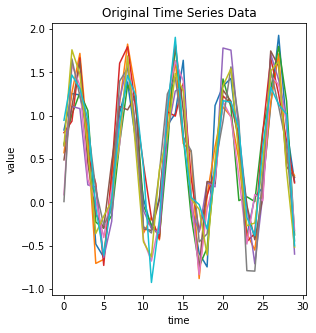

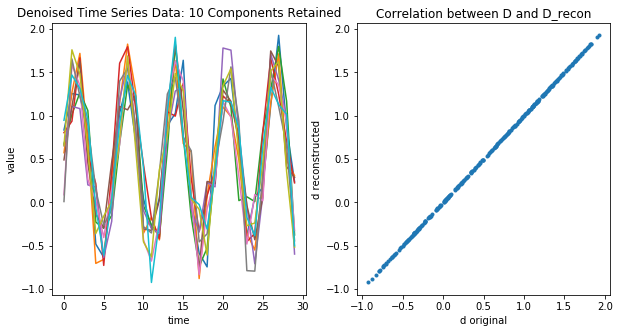

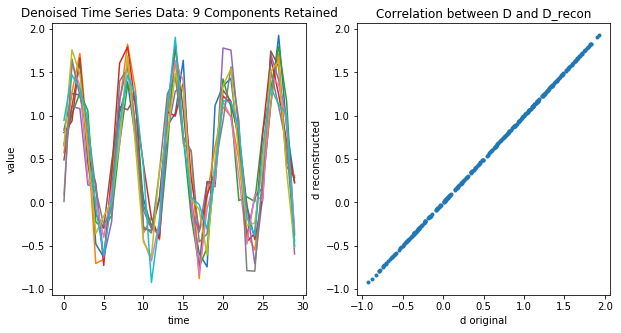

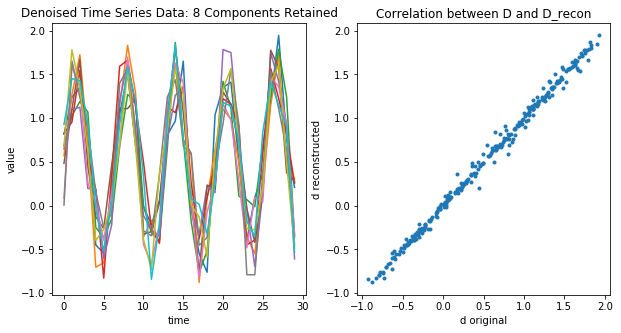

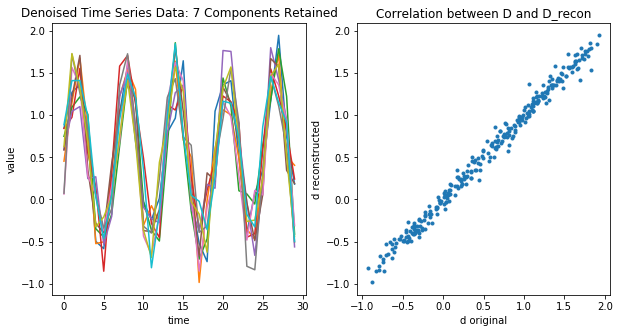

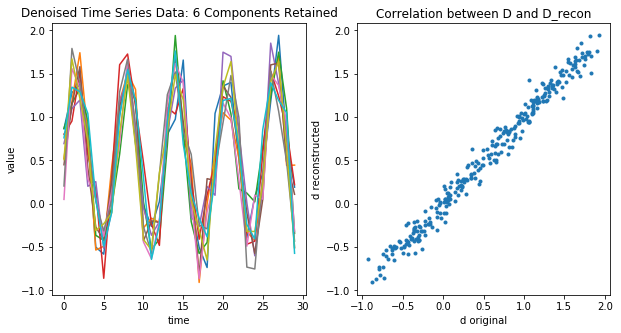

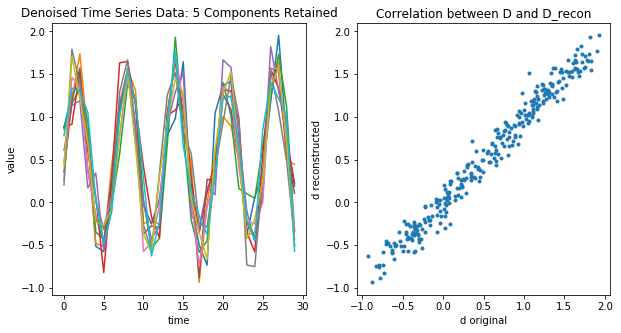

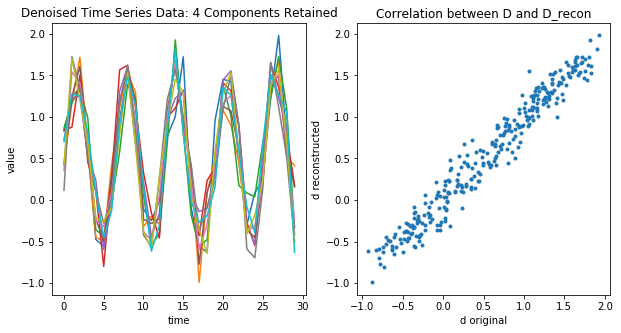

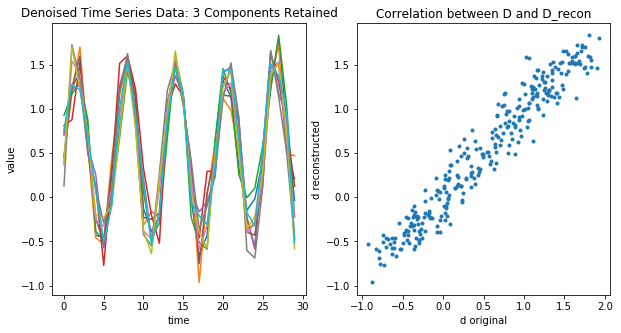

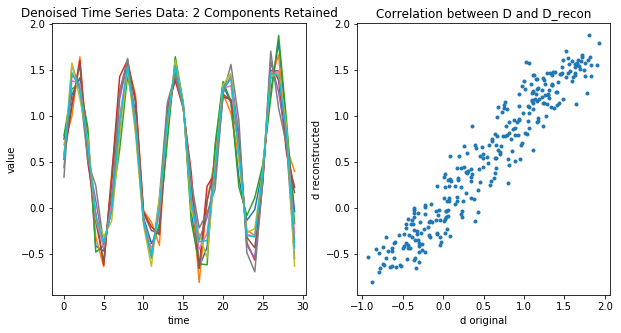

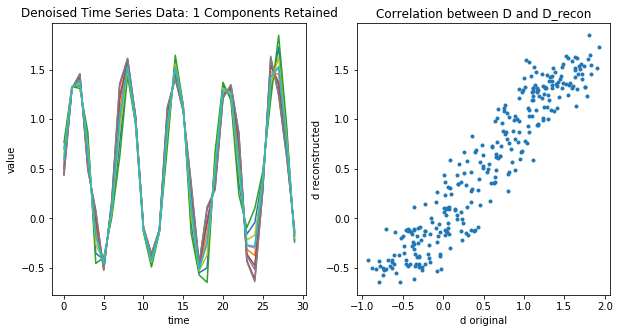

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(d.T);
plt.xlabel('time')
plt.ylabel('value')
plt.title(f'Original Time Series Data')
plt.show()

d_mean = np.mean(d,axis=0)
sklearn_pca = sklearnPCA(n_components=None)
sklearn_pca.fit(d)
tf = sklearn_pca.components_.T

for n in range(len(d),0, -1):
    #calculate reduced PC reconstruction
    tr = tf[:,:n]
    pr = (d-d_mean)@tr
    dr = pr@(tr.T) + d_mean
    
    #plot
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(dr.T);
    plt.xlabel('time')
    plt.ylabel('value')
    plt.title(f'Denoised Time Series Data: {n} Components Retained')
    plt.subplot(1,2,2)
    plt.plot(d.T.flatten(), dr.T.flatten(),'.');
    #plt.xlim(-1,2)
    #plt.ylim(-1,3)
    plt.ylabel('d reconstructed')
    plt.xlabel('d original')
    plt.title('Correlation between D and D_recon')
    plt.show()

The correlation falls off as we reduce to fewer and fewer PCs.

## Do this Using SVD Directly

Singular Value Decomposition (SVD) is the mathematical framework under the hood of SKLearn. We call call SVD directly to do the same thing.

Singular Value decomposition is used to factorize a matrix down into 3 matrices, $U$, $\Sigma$, and $V^*$:

$$M = U \Sigma V^*$$

These three matrices have many very special properties, but for the purposes of this tutorial, what is important to us is that $\Sigma$ is a diagonal matrix where the diagonal elements represent the sigular values. Because this structure is understood, the SVD call returns a vector of these diagonal entries rather than the full diagonal matrix, which is primarily zeros. In order to reconstruct, we simply re-create this $\Sigma$ matrix with the number of diagonal entries desired. The remaining are left as zeros, which zero-out the higher PC components from $U$ and $V^*$ when they are multiplied together to reconstruct.

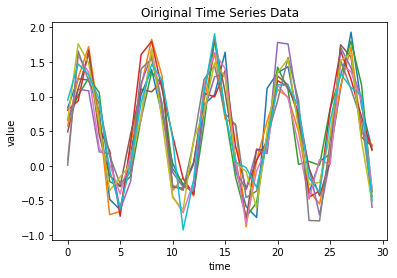

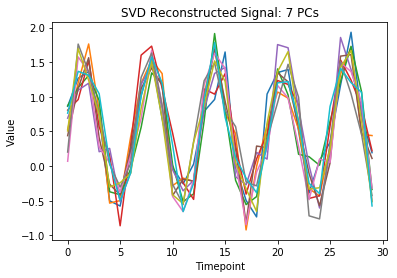

In [20]:
#call SVD to get our 3 matrices
u, s, v = np.linalg.svd(d)

n_components_kept = 7

# s is returned as a vector, but it really needs to be a
# rectangular matrix which match the u, v shapes.
# where the diagonal elements are filled in with the terms
# that were returned by the svd calculation.
# in this case, since we are only rebuilding a bit of the data
# we are not going to fill in all of them, we are only keeping the
# first 'n_components_kept' number of them.
s_new = np.zeros([u.shape[1], v.shape[0]])
for i in range(n_components_kept):
    s_new[i, i] = s[i]
    
#plot original
plt.plot(d.T);
plt.xlabel('time')
plt.ylabel('value')
plt.title(f'Oiriginal Time Series Data')
plt.show()    
    
# now we rebuild d, but with this 'incomplete' s matrix
plt.plot((u @ s_new @ v).T);
plt.xlabel('Timepoint')
plt.ylabel('Value')
plt.title(f'SVD Reconstructed Signal: {n_components_kept} PCs')
plt.show()



Text(0.5, 1.0, 'Correlation between D and D_recon')

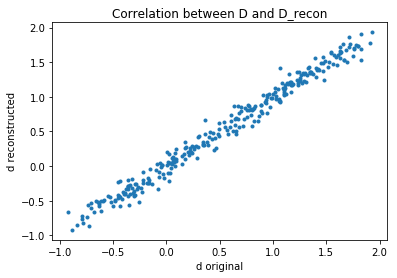

In [21]:
plt.plot(d.T.flatten(), (u @ s_new @ v).T.flatten(),'.');
plt.ylabel('d reconstructed')
plt.xlabel('d original')
plt.title('Correlation between D and D_recon')